# Proper Orthogonal Decomposition of Schlieren Images

## Big Data Final Project (Spring 2021)

### Written by Elijah LaLonde

This code takes schlieren images and preforms POD on the images, finding the different "modes" that create an orthonormal basis for the ensamble of images. In this code, snapshot POD is implemented. Snapshot POD differs from regular POD in one regard. Traditional POD solves the autocorrelation matrix that is:
$$K=Y\cdot Y^T$$
Where Y is the matrix whose columns correspond to each flattened images. The rows represent the "snapshots" of the floww in time. With some fancy maths, snapshot POD uses the autocorrelation matrix:
$$K=Y^T\cdot Y$$
The eigenvectors of this finds the optimal orthogonal basis for the image set and consequently reduces the size of the matrix you have to handle.

#### Import Libraries

In [1]:
# Libraries for GUI
import numpy as np
import pims
import pandas as pd
from tempfile import TemporaryFile
from scipy.linalg.blas import sgemm # A faster way of doing matrix multiplication
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import time
from astrodendro import Dendrogram
from astrodendro import Structure

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#### Load the data files

In [2]:
# Name the files to load
bg_file = 'Background AVI.avi'
butane_file = 'Butane Schlieren AVI.avi'

# Load the AVI files with pims
bg_avi = pims.Video(bg_file)
butane_avi = pims.Video(butane_file)

# Convert to greyscale
bg_avi = pims.as_grey(bg_avi) 
butane_avi = pims.as_grey(butane_avi)

#### Preview a background image

Frame([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
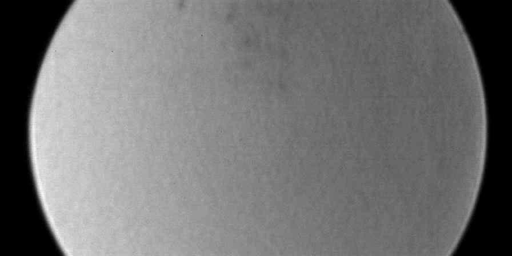

In [3]:
bg_avi[0]

#### Preview an image of the flow

Frame([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
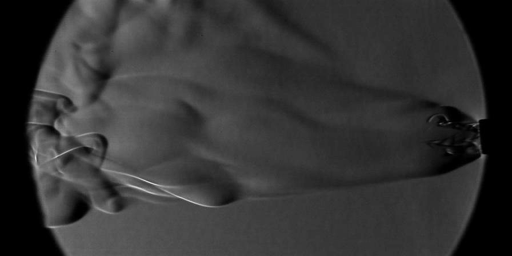

In [4]:
butane_avi[0]

#### Background function

This function pulls the background images from pims and calculates the mean image to use.

In [5]:
def Background(bg_avi,crop_px):
    
    t = len(bg_avi)
    X,Y = np.shape(bg_avi[0])
    Y = Y - 2*crop_px
    
    bg = np.zeros((t,X,Y), dtype = 'float32')
    print('Created background arrray of size:', np.shape(bg))
    i = 0
    for image in bg_avi:
        
        bg[i,:,:] = np.asarray(image[:, crop_px:-crop_px]) # Convert each image to a numpy array and crop accordingly
        i += 1 
        
    print('Calculating the mean background image...')
    bg_image = np.mean(bg, axis = 0) # Calculate the mean background image to be used
    print('Returning array...')
    return bg_image


####  Load_and_BG_subtraction function

This function loads the images from pims as numpy arrays and preforms backgorund subtraction on the images if the variable subtration is set to True.

In [6]:
def Load_and_BG_subtraction(butane_avi, num_frames, crop_px, bg = np.array([])):
    
    t = num_frames
    X,Y = np.shape(butane_avi[0])
    Y = Y - 2*crop_px
    
    if len(bg) > 0:
        print('Background subtraction selected...')
    
    images = np.zeros((t,X,Y), dtype = 'float32')
    print('Created image arrray of size:', np.shape(images))
    i = 0
    for image in butane_avi[0:num_frames]:

        im1 = np.asarray(image[:, crop_px:-crop_px]) # Convert each image to a numpy array and crop accordingly
        if len(bg) > 0:
            images[i,:,:] = (im1 + 255)/(bg + 255) # Do the background subtraction
        else:
            images[i,:,:] = im1 
            
        i += 1 
    if len(bg) > 0:     
        print('Rescaling images...')
        images = 255*images/images.max()
        
    return images

#### Snapshot POD function

This function carries out the actual POD algorithm and returns the normalized eigenvalue array, the total energy array, the modes requested, and the autocovariance matrix condition number.

In [7]:
def Snapshot_POD(imgs, modes_wanted, modes_to_corr):
    
    print('Calculating the mean image...')
    mean_image = np.mean(imgs, axis = 0) # calculate the mean image
    y_bar = mean_image.flatten('F') # We need the mean image flattened todo the POD
    
    y = np.zeros((len(y_bar),num_frames), dtype = 'float32') 

    for i in range(num_frames):
        y[:,i] = imgs[i,:,:].flatten('F') # Flatten the images

    del imgs

    print('Subtracting fluctuating properties...')
    for i in range(num_frames):
        y[:,i] = y[:,i] - y_bar # Keep only the fluctiuating properties

    print('Finding the autocovariance matrix...')
    K = sgemm(1.0, y.T, y) # The autocovariance matrix

    saved_y = TemporaryFile()
    np.save(saved_y, y)
    
    print('Solving the eigenvalue problem...')
    cond = np.linalg.cond(K)
    print('The condition number is:', round(cond,3))
    lamb, v = np.linalg.eig(K) # Solve for the eigenvalues and the eigenvectors

    saved_K = TemporaryFile()
    np.save(saved_K, K)
    del K

    I = np.argsort(lamb) # Get the index of the eigenvalues in descending order
    lamb = np.sort(lamb) # Sort the eigenvalues in ascending order
    lamb = np.flip(lamb).astype(np.float32)  # Flip them so they are now in descending order
    lamb[-1] = 0.01 # We need to make sure the last eigenvalue is zero
    I = np.flip(I) # Flip them so they are now in descending order
    v = v[::-1,list(I)].astype(np.float32) # Sort the eigenvectors accoring to the eigenvalues

    E = 0 
    E_tot = sum(lamb) # The total energy in the system
    E_sum = np.zeros(np.shape(lamb), dtype = 'float32')

    for i in range(num_frames): 
        E = E + lamb[i]/E_tot*100 # Calculate the total energy up to frame i
        E_sum[i] = E # Update the cumulativer energy array

    norm_lamb = 100*lamb/sum(lamb) # normalize the energy
    
    saved_lamb = TemporaryFile()
    np.save(saved_lamb, lamb)
    del lamb

    saved_norm_lamb = TemporaryFile()
    np.save(saved_norm_lamb, norm_lamb)
    del norm_lamb

    saved_E_sum = TemporaryFile()
    np.save(saved_E_sum, E_sum)
    del E_sum
    
    print('Creating basis vectors...')
    t7 = time.time()
    
    # Reload y
    _ = saved_y.seek(0) # Only needed here to simulate closing & reopening file
    y = np.load(saved_y)

    a = sgemm(1.0, y, v).astype(np.float32)# This is shorter by like 8 minutes lol

    del y

    t8 = time.time()

    print('Creating basis vectors took', round((t8-t7)/60, 3), 'minutes to find')
    
    # Reload the eigenvalues
    _ = saved_lamb.seek(0) # Only needed here to simulate closing & reopening file
    lamb = np.load(saved_lamb)

    modes = np.arange(0,num_frames)

    t9 = time.time()

    X_shape, Y_shape = np.shape(mean_image)
    num_modes = len(modes)

    u = np.zeros((len(y_bar),num_modes), dtype = 'float32')

    j = 0
    for mode in modes:

        u[:,j] = a[:,mode]/np.sqrt(lamb[mode]) 
        j += 1

    t10 = time.time()

    print('Generating the modes took:', round((t10-t9)/60, 3), 'minutes')
    
    basis_modes = np.zeros((X_shape,Y_shape, len(modes_wanted)), dtype = 'float32')

    i = 0
    for mode in modes_wanted:

        basis_modes[:,:,i] = np.reshape(u[:,mode], (X_shape,Y_shape), order='F')

        i += 1
        
    corr_modes = np.zeros((X_shape,Y_shape, len(modes_to_corr)), dtype = 'float32')
    i = 0
    for mode in modes_to_corr:

        corr_modes[:,:,i] = np.reshape(u[:,mode], (X_shape,Y_shape), order='F')

        i += 1

    _ = saved_norm_lamb.seek(0) # Only needed here to simulate closing & reopening file
    norm_lamb = np.load(saved_norm_lamb)
    
    _ = saved_E_sum.seek(0) # Only needed here to simulate closing & reopening file
    E_sum = np.load(saved_E_sum)
    
    print('POD finished for ', round(len(E_sum),3), 'images')
    
    return norm_lamb, E_sum, basis_modes, corr_modes, cond


#### Calculate the mean background image

In [8]:
crop_px = 40 # How many pixels to prop off the sides
t1 = time.time()
bg = Background(bg_avi,crop_px)
t2 = time.time()
print('It took', round(t2-t1,3), 'seconds to load and calculate the background image')

Created background arrray of size: (2001, 448, 816)
Calculating the mean background image...
Returning array...
It took 15.368 seconds to load and calculate the background image


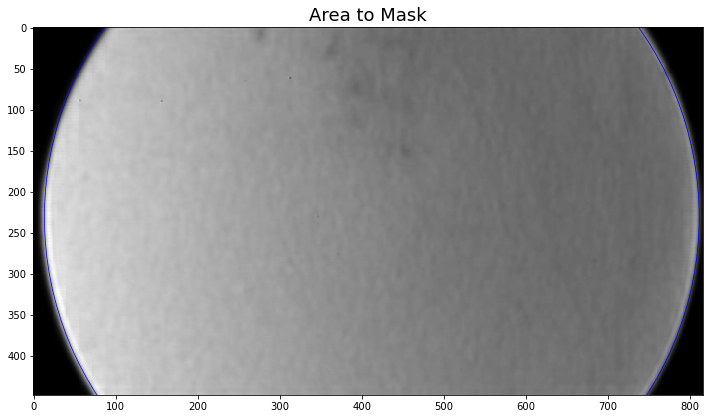

In [9]:
figure, ax = plt.subplots(1, 1) # Initiate the figure and the subplots
figure.set_size_inches(12, 10) # Set the figure size

plt.rcParams["font.family"] = "Times New Roman"

X_center = 412
Y_center = 231
radius = 399

background_plot = ax.imshow(bg, cmap = 'gray')
circ1 = Circle((X_center, Y_center), radius, facecolor='None', edgecolor='b', lw=0.75)
ax.add_patch(circ1)
plt.title('Area to Mask', fontsize = 18)
plt.show()

In [10]:
X,Y = np.shape(butane_avi[0])
Y = Y - 2*crop_px
mask_array = np.zeros(np.shape(bg))
# make the background black
for j in range(X):
    for k in range(Y):
        if np.sqrt((j-Y_center)**2 +(k-X_center)**2) >= radius:
            mask_array[j,k] = 1
        else:
            mask_array[j,k] = mask_array[j,k]

#### Prep all the first images for analysis

In [11]:
num_frames = 2000 # I don't advise going over 12k images... and thats if you have about 32gb of ram and time 
t3 = time.time()
imgs = Load_and_BG_subtraction(butane_avi, num_frames,crop_px, bg) # Call the function to prep the images
t4 = time.time()
print('It took', round(t4-t3,3), 'seconds to load the images and do the background subtraction')
print('It took', round((t4-t1)/60,3), 'minutes to load and prep images', num_frames + 1, 'for POD')

Background subtraction selected...
Created image arrray of size: (2000, 448, 816)
Rescaling images...
It took 20.384 seconds to load the images and do the background subtraction
It took 0.609 minutes to load and prep images 2001 for POD


#### Call the POD function for the different number of snapshots

In [12]:
modes_wanted_2k = np.array([0,1,2,3,10,20,100,200,1000,num_frames-2])
modes_to_corr = np.arange(0,50)
X,Y = np.shape(imgs[0,:,:])
# make the background black
for j in range(X):
    for k in range(Y):
        if np.sqrt((j-Y_center)**2 +(k-X_center)**2) >= radius:
            imgs[:,j,k] = 0

        else:
            imgs[:,j,k] = imgs[:,j,k]

norm_lamb_2k, E_sum_2k, basis_modes_2k, corr_modes_2k, cond_2k = Snapshot_POD(imgs, modes_wanted_2k, modes_to_corr)

saved_norm_lamb_2k = TemporaryFile()
np.save(saved_norm_lamb_2k, norm_lamb_2k)
del norm_lamb_2k

saved_E_sum_2k = TemporaryFile()
np.save(saved_E_sum_2k, E_sum_2k)
del E_sum_2k

saved_basis_modes_2k = TemporaryFile()
np.save(saved_basis_modes_2k, basis_modes_2k)
del basis_modes_2k

saved_corr_modes_2k = TemporaryFile()
np.save(saved_corr_modes_2k, corr_modes_2k)
del corr_modes_2k

num_frames = 3000
modes_wanted_3k = np.array([0,1,2,3,10,20,100,200,1000,num_frames-2])
imgs = Load_and_BG_subtraction(butane_avi, num_frames,crop_px, bg) # Call the function to prep the images

# make the background black
for j in range(X):
    for k in range(Y):
        if np.sqrt((j-Y_center)**2 +(k-X_center)**2) >= radius:
            imgs[:,j,k] = 0

        else:
            imgs[:,j,k] = imgs[:,j,k]

norm_lamb_3k, E_sum_3k, basis_modes_3k, corr_modes_3k, cond_3k = Snapshot_POD(imgs, modes_wanted_3k, modes_to_corr)

saved_norm_lamb_3k = TemporaryFile()
np.save(saved_norm_lamb_3k, norm_lamb_3k)
del norm_lamb_3k

saved_E_sum_3k = TemporaryFile()
np.save(saved_E_sum_3k, E_sum_3k)
del E_sum_3k

saved_basis_modes_3k = TemporaryFile()
np.save(saved_basis_modes_3k, basis_modes_3k)
del basis_modes_3k

saved_corr_modes_3k = TemporaryFile()
np.save(saved_corr_modes_3k, corr_modes_3k)
del corr_modes_3k

num_frames = 4000
modes_wanted_4k = np.array([0,1,2,3,10,20,100,200,1000,num_frames-2])
imgs = Load_and_BG_subtraction(butane_avi, num_frames,crop_px, bg) # Call the function to prep the images

# make the background black
for j in range(X):
    for k in range(Y):
        if np.sqrt((j-Y_center)**2 +(k-X_center)**2) >= radius:
            imgs[:,j,k] = 0

        else:
            imgs[:,j,k] = imgs[:,j,k]

norm_lamb_4k, E_sum_4k, basis_modes_4k, corr_modes_4k, cond_4k = Snapshot_POD(imgs, modes_wanted_4k, modes_to_corr)

saved_norm_lamb_4k = TemporaryFile()
np.save(saved_norm_lamb_4k, norm_lamb_4k)
del norm_lamb_4k

saved_E_sum_4k = TemporaryFile()
np.save(saved_E_sum_4k, E_sum_4k)
del E_sum_4k

saved_basis_modes_4k = TemporaryFile()
np.save(saved_basis_modes_4k, basis_modes_4k)
del basis_modes_4k

saved_corr_modes_4k = TemporaryFile()
np.save(saved_corr_modes_4k, corr_modes_4k)
del corr_modes_4k

num_frames = 5000 
modes_wanted_5k = np.array([0,1,2,3,10,20,100,200,1000,num_frames-2])
imgs = Load_and_BG_subtraction(butane_avi, num_frames,crop_px, bg) # Call the function to prep the images

# make the background black
for j in range(X):
    for k in range(Y):
        if np.sqrt((j-Y_center)**2 +(k-X_center)**2) >= radius:
            imgs[:,j,k] = 0

        else:
            imgs[:,j,k] = imgs[:,j,k]

norm_lamb_5k, E_sum_5k, basis_modes_5k, corr_modes_5k, cond_5k = Snapshot_POD(imgs, modes_wanted_5k, modes_to_corr)

saved_norm_lamb_5k = TemporaryFile()
np.save(saved_norm_lamb_5k, norm_lamb_5k)
del norm_lamb_5k

saved_E_sum_5k = TemporaryFile()
np.save(saved_E_sum_5k, E_sum_5k)
del E_sum_5k

saved_basis_modes_5k = TemporaryFile()
np.save(saved_basis_modes_5k, basis_modes_5k)
del basis_modes_5k

saved_corr_modes_5k = TemporaryFile()
np.save(saved_corr_modes_5k, corr_modes_5k)
del corr_modes_5k

num_frames = 10000 
modes_wanted_10k = np.array([0,1,2,3,10,20,100,200,1000,num_frames-2])
imgs = Load_and_BG_subtraction(butane_avi, num_frames,crop_px, bg) # Call the function to prep the images

# make the background black
for j in range(X):
    for k in range(Y):
        if np.sqrt((j-Y_center)**2 +(k-X_center)**2) >= radius:
            imgs[:,j,k] = 0

        else:
            imgs[:,j,k] = imgs[:,j,k]


norm_lamb_10k, E_sum_10k, basis_modes_10k, corr_modes_10k, cond_10k = Snapshot_POD(imgs, modes_wanted_10k, modes_to_corr)

saved_norm_lamb_10k = TemporaryFile()
np.save(saved_norm_lamb_10k, norm_lamb_10k)
del norm_lamb_10k

saved_E_sum_10k = TemporaryFile()
np.save(saved_E_sum_10k, E_sum_10k)
del E_sum_10k

saved_basis_modes_10k = TemporaryFile()
np.save(saved_basis_modes_10k, basis_modes_10k)
del basis_modes_10k

saved_corr_modes_10k = TemporaryFile()
np.save(saved_corr_modes_10k, corr_modes_10k)
del corr_modes_10k

num_frames = 12000
modes_wanted_12k = np.array([0,1,2,3,10,20,100,200,1000,num_frames-2])
imgs = Load_and_BG_subtraction(butane_avi, num_frames,crop_px, bg) # Call the function to prep the images

# make the background black
for j in range(X):
    for k in range(Y):
        if np.sqrt((j-Y_center)**2 +(k-X_center)**2) >= radius:
            imgs[:,j,k] = 0

        else:
            imgs[:,j,k] = imgs[:,j,k]


norm_lamb_12k, E_sum_12k, basis_modes_12k, corr_modes_12k, cond_12k = Snapshot_POD(imgs, modes_wanted_12k, modes_to_corr)  

saved_norm_lamb_12k = TemporaryFile()
np.save(saved_norm_lamb_12k, norm_lamb_12k)
del norm_lamb_12k

saved_E_sum_12k = TemporaryFile()
np.save(saved_E_sum_12k, E_sum_12k)
del E_sum_12k

saved_basis_modes_12k = TemporaryFile()
np.save(saved_basis_modes_12k, basis_modes_12k)
del basis_modes_12k

saved_corr_modes_12k = TemporaryFile()
np.save(saved_corr_modes_12k, corr_modes_12k)
del corr_modes_12k

condition_num = np.array([cond_2k, cond_3k, cond_4k, cond_5k, cond_10k, cond_12k])

Calculating the mean image...
Subtracting fluctuating properties...
Finding the autocovariance matrix...
Solving the eigenvalue problem...
The condition number is: 2851387.0
Creating basis vectors...
Creating basis vectors took 0.237 minutes to find
Generating the modes took: 0.162 minutes
POD finished for  2000 images
Background subtraction selected...
Created image arrray of size: (3000, 448, 816)
Rescaling images...
Calculating the mean image...
Subtracting fluctuating properties...
Finding the autocovariance matrix...
Solving the eigenvalue problem...
The condition number is: 734589.5
Creating basis vectors...
Creating basis vectors took 0.463 minutes to find
Generating the modes took: 0.244 minutes
POD finished for  3000 images
Background subtraction selected...
Created image arrray of size: (4000, 448, 816)
Rescaling images...
Calculating the mean image...
Subtracting fluctuating properties...
Finding the autocovariance matrix...
Solving the eigenvalue problem...
The condition nu

#### Load the energy arrays for plotting

In [13]:
_ = saved_norm_lamb_2k.seek(0) # Only needed here to simulate closing & reopening file
norm_lamb_2k = np.load(saved_norm_lamb_2k)

_ = saved_E_sum_2k.seek(0) # Only needed here to simulate closing & reopening file
E_sum_2k = np.load(saved_E_sum_2k)

_ = saved_norm_lamb_3k.seek(0) # Only needed here to simulate closing & reopening file
norm_lamb_3k = np.load(saved_norm_lamb_3k)

_ = saved_E_sum_3k.seek(0) # Only needed here to simulate closing & reopening file
E_sum_3k = np.load(saved_E_sum_3k)

_ = saved_norm_lamb_4k.seek(0) # Only needed here to simulate closing & reopening file
norm_lamb_4k = np.load(saved_norm_lamb_4k)

_ = saved_E_sum_4k.seek(0) # Only needed here to simulate closing & reopening file
E_sum_4k = np.load(saved_E_sum_4k)

_ = saved_norm_lamb_5k.seek(0) # Only needed here to simulate closing & reopening file
norm_lamb_5k = np.load(saved_norm_lamb_5k)

_ = saved_E_sum_5k.seek(0) # Only needed here to simulate closing & reopening file
E_sum_5k = np.load(saved_E_sum_5k)

_ = saved_norm_lamb_10k.seek(0) # Only needed here to simulate closing & reopening file
norm_lamb_10k = np.load(saved_norm_lamb_10k)

_ = saved_E_sum_10k.seek(0) # Only needed here to simulate closing & reopening file
E_sum_10k = np.load(saved_E_sum_10k)

_ = saved_norm_lamb_12k.seek(0) # Only needed here to simulate closing & reopening file
norm_lamb_12k = np.load(saved_norm_lamb_12k)

_ = saved_E_sum_12k.seek(0) # Only needed here to simulate closing & reopening file
E_sum_12k = np.load(saved_E_sum_12k)

#### Plotting Data

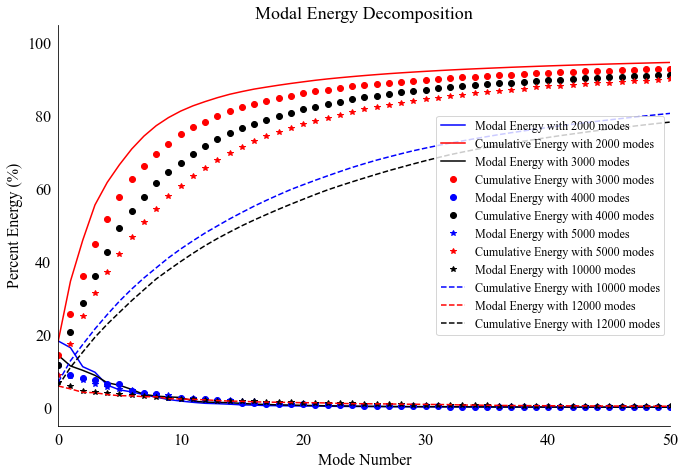

In [14]:
figure, ax = plt.subplots(1)
figure.set_size_inches(9,6)
figure.tight_layout(pad=0.5)

plt.rcParams["font.family"] = "Times New Roman"

plt.plot(norm_lamb_2k, 'b', label = 'Modal Energy with 2000 modes')
plt.plot(E_sum_2k, 'r', label = 'Cumulative Energy with 2000 modes')

plt.plot(norm_lamb_3k, 'k', label = 'Modal Energy with 3000 modes')
plt.plot(E_sum_3k, 'ro', label = 'Cumulative Energy with 3000 modes')

plt.plot(norm_lamb_4k, 'bo', label = 'Modal Energy with 4000 modes')
plt.plot(E_sum_4k, 'ko', label = 'Cumulative Energy with 4000 modes')

plt.plot(norm_lamb_5k, 'b*', label = 'Modal Energy with 5000 modes')
plt.plot(E_sum_5k, 'r*', label = 'Cumulative Energy with 5000 modes')

plt.plot(norm_lamb_10k, 'k*', label = 'Modal Energy with 10000 modes')
plt.plot(E_sum_10k, 'b--', label = 'Cumulative Energy with 10000 modes')

plt.plot(norm_lamb_12k, 'r--', label = 'Modal Energy with 12000 modes')
plt.plot(E_sum_12k, 'k--', label = 'Cumulative Energy with 12000 modes')


plt.title('Modal Energy Decomposition', fontsize = 18)
plt.xlabel('Mode Number', fontsize = 16)
plt.ylabel('Percent Energy (%)', fontsize = 16)
plt.xlim([0,50])
plt.legend(fontsize = 12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.tick_params(axis = "x", which = "both", bottom = False, top = False, labelsize=16)
plt.tick_params(axis = "y", which = "both", left = False, right = False, labelsize=16)

plt.savefig('Modal Energy.tif', dpi=300, bbox_inches='tight')

In [15]:
# Delete arrays we don't need anymore
del E_sum_2k
del E_sum_3k
del E_sum_4k
del E_sum_5k
del E_sum_10k
del E_sum_12k

In [16]:
# Load the modal arrays
_ = saved_basis_modes_2k.seek(0) # Only needed here to simulate closing & reopening file
basis_modes_2k = np.load(saved_basis_modes_2k)

_ = saved_basis_modes_3k.seek(0) # Only needed here to simulate closing & reopening file
basis_modes_3k = np.load(saved_basis_modes_3k)

_ = saved_basis_modes_4k.seek(0) # Only needed here to simulate closing & reopening file
basis_modes_4k = np.load(saved_basis_modes_4k)

_ = saved_basis_modes_5k.seek(0) # Only needed here to simulate closing & reopening file
basis_modes_5k = np.load(saved_basis_modes_5k)

_ = saved_basis_modes_10k.seek(0) # Only needed here to simulate closing & reopening file
basis_modes_10k = np.load(saved_basis_modes_10k)

_ = saved_basis_modes_12k.seek(0) # Only needed here to simulate closing & reopening file
basis_modes_12k = np.load(saved_basis_modes_12k)

It was hypothesised that because a lot of the flame is relativly laminar, that 90% of the total energy would be contained in the first 5 modes. It was quickly discovered that this is not the case. To account for 90% of the energy when using 2000 images, approximatly 30 modes are required.

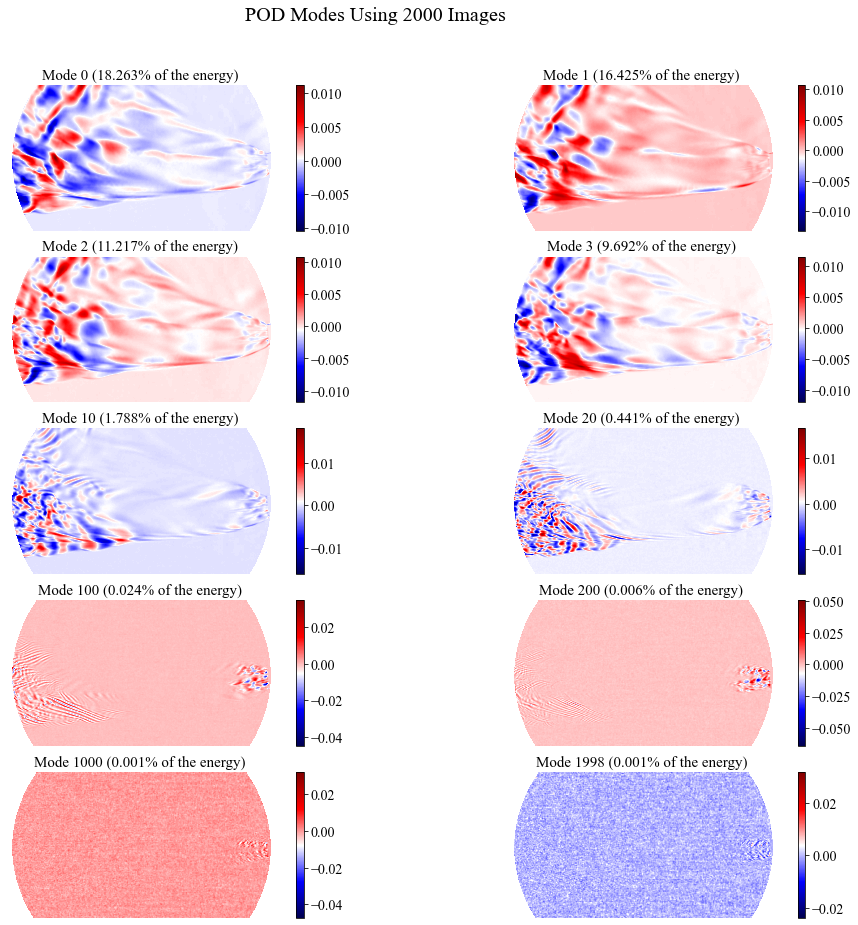

In [17]:
figure, ax = plt.subplots(5,2)
figure.set_size_inches(14,12)
figure.tight_layout(pad=0.5)

plt.rcParams["font.family"] = "Times New Roman"

figure.suptitle('POD Modes Using 2000 Images', fontsize=20, y = 1.08)

k = 0
for i in range(5):
    for j in range(2):
                
        plt.sca(ax[i,j])
        mode = plt.imshow(np.ma.array(basis_modes_2k[:,:,k], mask = mask_array), cmap = 'seismic')
        cbar = figure.colorbar(mode)     
        cbar.ax.tick_params(labelsize=14) 
        plt.title('Mode ' + str(modes_wanted_2k[k]) + ' (' + str(round(norm_lamb_2k[modes_wanted_2k[k]],3)) 
                  + '% of the energy)', fontsize = 15)
        ax[i,j].axis('off') # Hide the xy axis marks, they just show pixel counts
        k += 1
        
plt.savefig('POD Modes with 2k images.tif', dpi=300, bbox_inches='tight')

It was additionally hypothesised that because the most turbulent part of the flow is at the end of the flame, that the higher modes, which show the smaller scale structures of the flow, would have the energy concentrated at the edge of the flame. Analysis of the modes shows that this is mostly correct. It has been found that while most of the energy is concentrated at the end of the flame for the mid-range modes, there is a higher than expected concentration of energy at the torch nozzle exit and the highest modes have all of their energy concentrated at the nozzle exit.

#### Dengrogam calculation and plotting

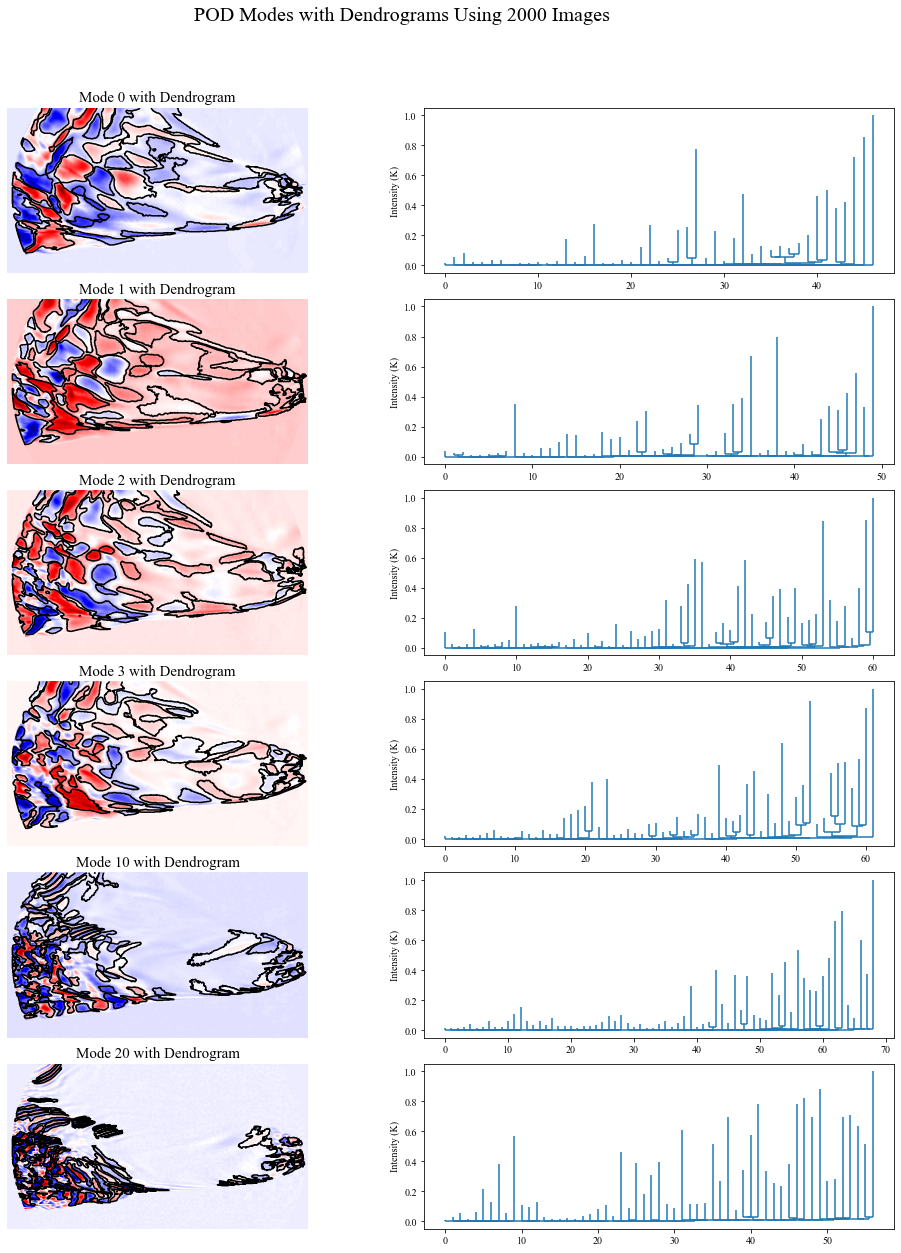

In [18]:
figure, ax = plt.subplots(6,2)
figure.set_size_inches(14,16)
figure.tight_layout(pad=0.5)

plt.rcParams["font.family"] = "Times New Roman"

figure.suptitle('POD Modes with Dendrograms Using 2000 Images', fontsize=20, y = 1.08)


for i in range(6):
    # We have to have all the fluctiations positive for the dendrogram to find everything the right way
    im = (basis_modes_2k[:,:,i]/abs(basis_modes_2k[:,:,i]).max())**2
    d = Dendrogram.compute(im,min_delta=0.01, min_npix=400) # All dendrogram code came from LaLonde and Brun Prjoect 2.
    p = d.plotter() # All dendrogram code came from LaLonde and Brun Prjoect 2.
    
    for j in range(2):
        plt.sca(ax[i,j])
    
        if j == 0:
            mode = plt.imshow(basis_modes_2k[:,:,i], cmap = 'seismic')
            plt.title('Mode ' + str(modes_wanted_2k[i]) + ' with Dendrogram', fontsize = 15)
            ax[i,j].axis('off') # Hide the xy axis marks, they just show pixel counts
            
            for leaf in d.leaves: # All dendrogram code came from LaLonde and Brun Prjoect 2.
                p.plot_contour(plt.gca(), structure=leaf, colors='black') # All dendrogram code came from LaLonde and Brun Prjoect 2.
            
        if j == 1:
            d.plotter().plot_tree(plt.gca()) # All dendrogram code came from LaLonde and Brun Prjoect 2. 
            plt.ylabel("Intensity (K)") # All dendrogram code came from LaLonde and Brun Prjoect 2.
            
plt.savefig('POD Modes and dend with 2k images.tif', dpi=300, bbox_inches='tight')

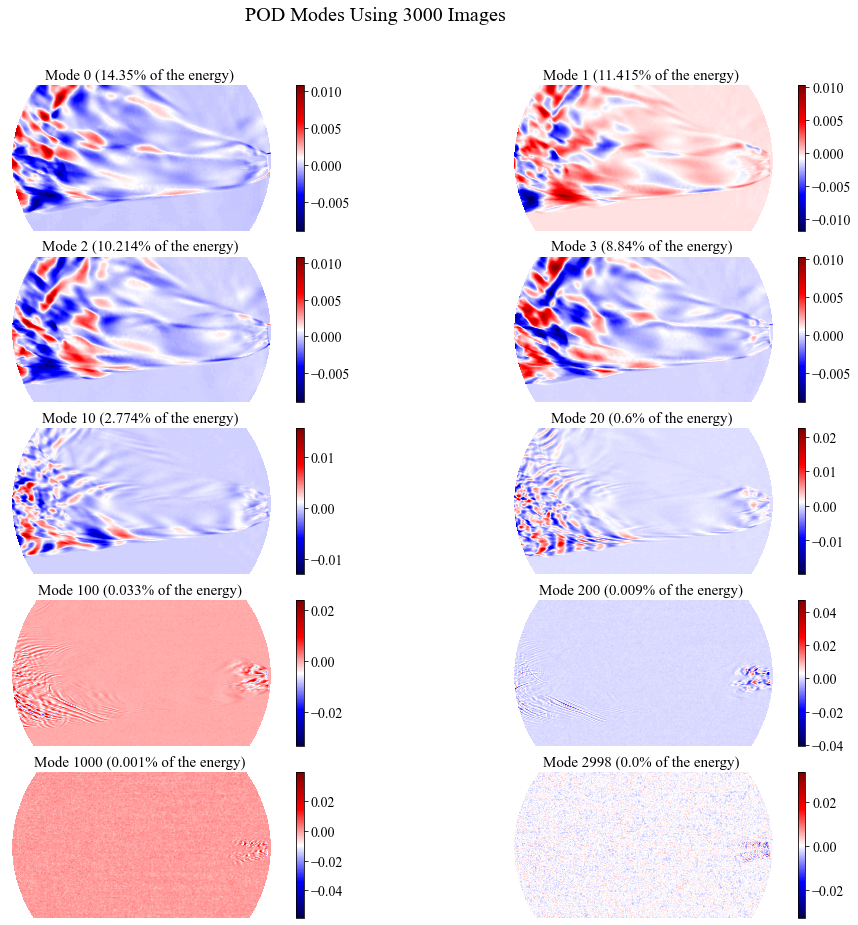

In [19]:
figure, ax = plt.subplots(5,2)
figure.set_size_inches(14,12)
figure.tight_layout(pad=0.5)

plt.rcParams["font.family"] = "Times New Roman"

figure.suptitle('POD Modes Using 3000 Images', fontsize=20, y = 1.08)

k = 0
for i in range(5):
    for j in range(2):
                
        plt.sca(ax[i,j])
        mode = plt.imshow(np.ma.array(basis_modes_3k[:,:,k], mask = mask_array), cmap = 'seismic')
        cbar = figure.colorbar(mode)     
        cbar.ax.tick_params(labelsize=14) 
        plt.title('Mode ' + str(modes_wanted_3k[k]) + ' (' + str(round(norm_lamb_3k[modes_wanted_3k[k]],3)) 
                  + '% of the energy)', fontsize = 15)
        ax[i,j].axis('off') # Hide the xy axis marks, they just show pixel counts
        k += 1
        
plt.savefig('POD Modes with 3k images.tif', dpi=300, bbox_inches='tight')

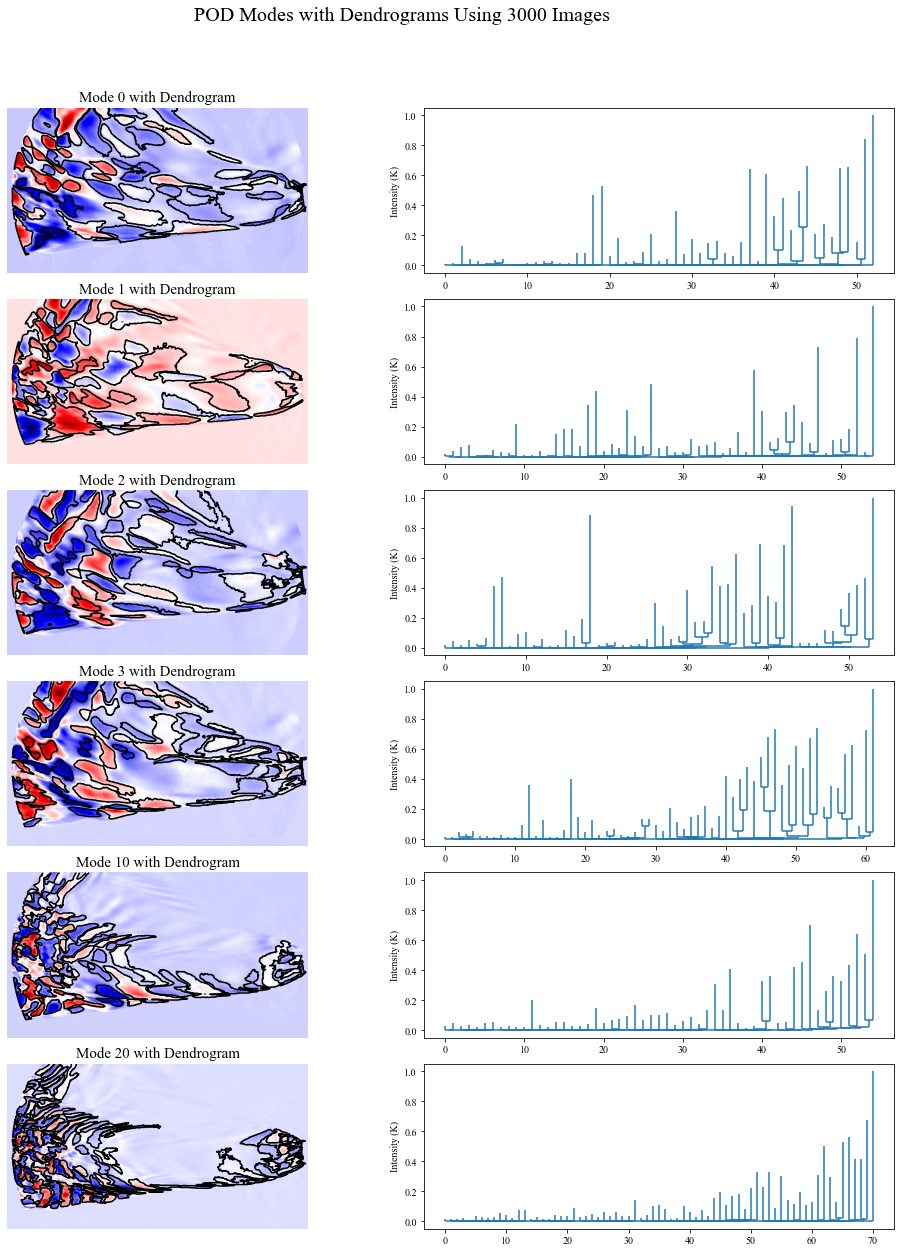

In [20]:
figure, ax = plt.subplots(6,2)
figure.set_size_inches(14,16)
figure.tight_layout(pad=0.5)

plt.rcParams["font.family"] = "Times New Roman"

figure.suptitle('POD Modes with Dendrograms Using 3000 Images', fontsize=20, y = 1.08)


for i in range(6):
    # We have to have all the fluctiations positive for the dendrogram to find everything the right way
    im = (basis_modes_3k[:,:,i]/abs(basis_modes_3k[:,:,i]).max())**2 
    d = Dendrogram.compute(im,min_delta=0.01, min_npix=400) # All dendrogram code came from LaLonde and Brun Prjoect 2.
    p = d.plotter() # All dendrogram code came from LaLonde and Brun Prjoect 2.
    
    for j in range(2):
        plt.sca(ax[i,j])
    
        if j == 0:
            mode = plt.imshow(basis_modes_3k[:,:,i], cmap = 'seismic')
            plt.title('Mode ' + str(modes_wanted_3k[i]) + ' with Dendrogram', fontsize = 15)
            ax[i,j].axis('off') # Hide the xy axis marks, they just show pixel counts
            
            for leaf in d.leaves: # All dendrogram code came from LaLonde and Brun Prjoect 2.
                p.plot_contour(plt.gca(), structure=leaf, colors='black') # All dendrogram code came from LaLonde and Brun Prjoect 2.
            
        if j == 1:
            d.plotter().plot_tree(plt.gca()) # All dendrogram code came from LaLonde and Brun Prjoect 2.
            plt.ylabel("Intensity (K)") # All dendrogram code came from LaLonde and Brun Prjoect 2.
            
plt.savefig('POD Modes and dend with 3k images.tif', dpi=300, bbox_inches='tight')

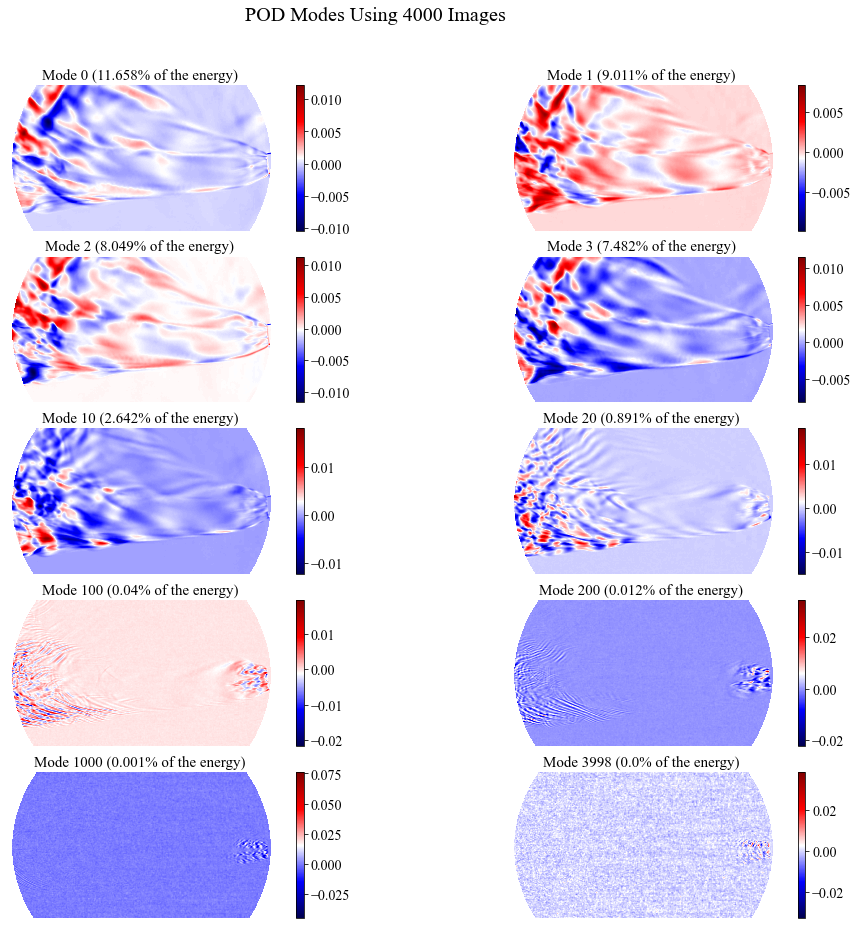

In [21]:
figure, ax = plt.subplots(5,2)
figure.set_size_inches(14,12)
figure.tight_layout(pad=0.5)

plt.rcParams["font.family"] = "Times New Roman"

figure.suptitle('POD Modes Using 4000 Images', fontsize=20, y = 1.08)

k = 0
for i in range(5):
    for j in range(2):
                
        plt.sca(ax[i,j])
        mode = plt.imshow(np.ma.array(basis_modes_4k[:,:,k], mask = mask_array), cmap = 'seismic')
        cbar = figure.colorbar(mode)     
        cbar.ax.tick_params(labelsize=14) 
        plt.title('Mode ' + str(modes_wanted_4k[k]) + ' (' + str(round(norm_lamb_4k[modes_wanted_4k[k]],3)) 
                  + '% of the energy)', fontsize = 15)
        ax[i,j].axis('off') # Hide the xy axis marks, they just show pixel counts
        k += 1
        
plt.savefig('POD Modes with 4k images.tif', dpi=300, bbox_inches='tight')

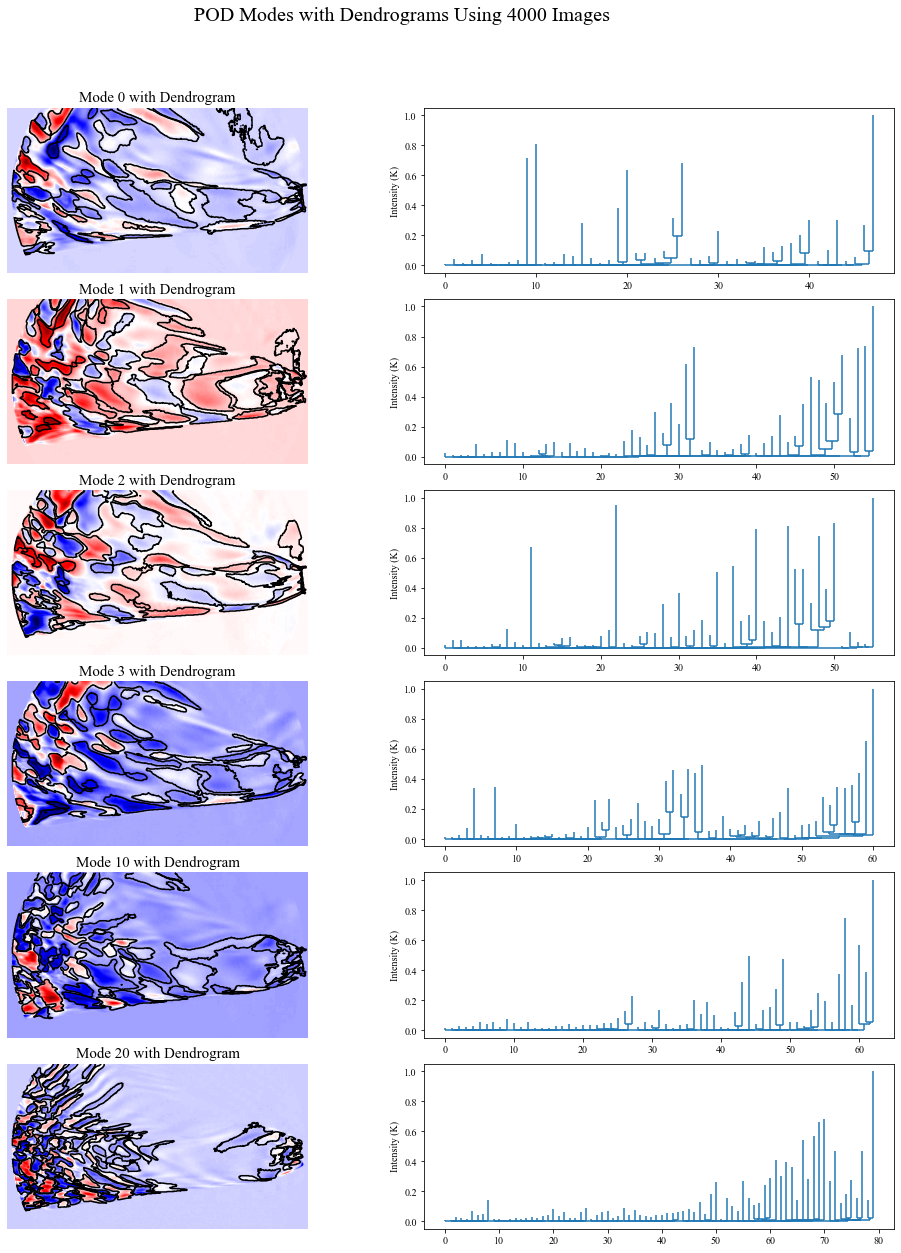

In [22]:
figure, ax = plt.subplots(6,2)
figure.set_size_inches(14,16)
figure.tight_layout(pad=0.5)

plt.rcParams["font.family"] = "Times New Roman"

figure.suptitle('POD Modes with Dendrograms Using 4000 Images', fontsize=20, y = 1.08)


for i in range(6):
    # We have to have all the fluctiations positive for the dendrogram to find everything the right way
    im = (basis_modes_4k[:,:,i]/abs(basis_modes_4k[:,:,i]).max())**2
    d = Dendrogram.compute(im,min_delta=0.01, min_npix=400) # All dendrogram code came from LaLonde and Brun Prjoect 2.
    p = d.plotter() # All dendrogram code came from LaLonde and Brun Prjoect 2.
    
    for j in range(2):
        plt.sca(ax[i,j])
    
        if j == 0:
            mode = plt.imshow(basis_modes_4k[:,:,i], cmap = 'seismic')
            plt.title('Mode ' + str(modes_wanted_4k[i]) + ' with Dendrogram', fontsize = 15)
            ax[i,j].axis('off') # Hide the xy axis marks, they just show pixel counts
            
            for leaf in d.leaves: # All dendrogram code came from LaLonde and Brun Prjoect 2.
                p.plot_contour(plt.gca(), structure=leaf, colors='black') # All dendrogram code came from LaLonde and Brun Prjoect 2.
            
        if j == 1:
            d.plotter().plot_tree(plt.gca())  # All dendrogram code came from LaLonde and Brun Prjoect 2.
            plt.ylabel("Intensity (K)") # All dendrogram code came from LaLonde and Brun Prjoect 2.
            
plt.savefig('POD Modes and dend with 4k images.tif', dpi=300, bbox_inches='tight')

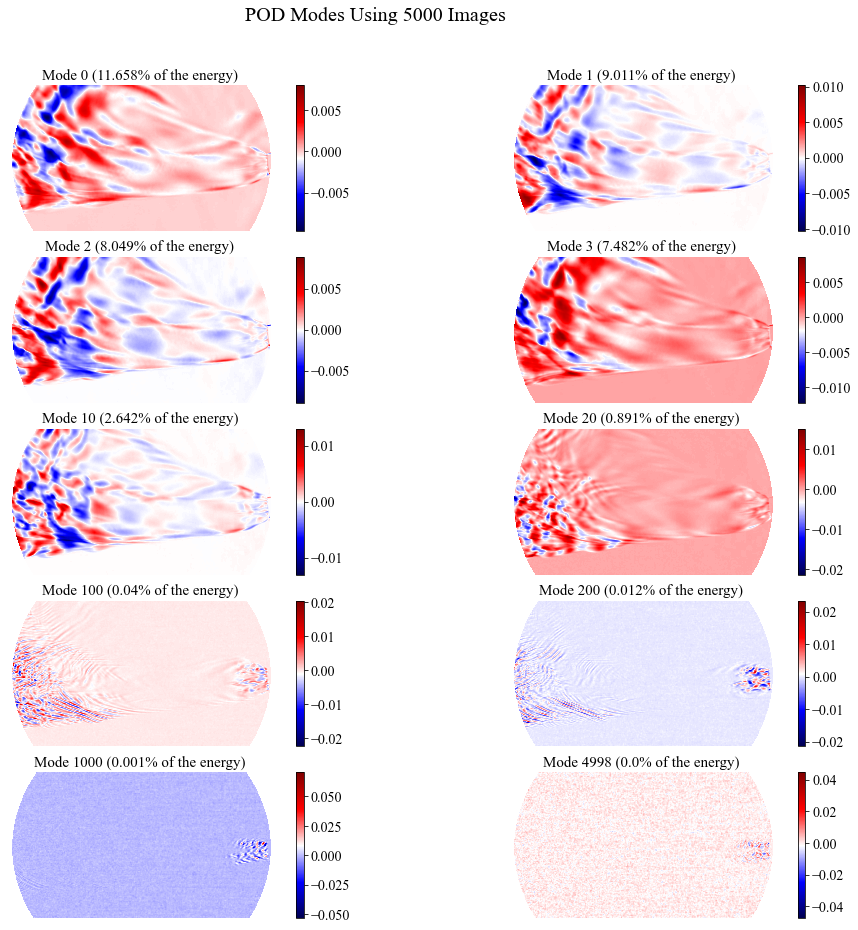

In [23]:
figure, ax = plt.subplots(5,2)
figure.set_size_inches(14,12)
figure.tight_layout(pad=0.5)

plt.rcParams["font.family"] = "Times New Roman"

figure.suptitle('POD Modes Using 5000 Images', fontsize=20, y = 1.08)

k = 0
for i in range(5):
    for j in range(2):
                
        plt.sca(ax[i,j])
        mode = plt.imshow(np.ma.array(basis_modes_5k[:,:,k], mask = mask_array), cmap = 'seismic')
        cbar = figure.colorbar(mode)     
        cbar.ax.tick_params(labelsize=14) 
        plt.title('Mode ' + str(modes_wanted_5k[k]) + ' (' + str(round(norm_lamb_4k[modes_wanted_4k[k]],3)) 
                  + '% of the energy)', fontsize = 15)
        ax[i,j].axis('off') # Hide the xy axis marks, they just show pixel counts
        k += 1
        
plt.savefig('POD Modes with 5k images.tif', dpi=300, bbox_inches='tight')

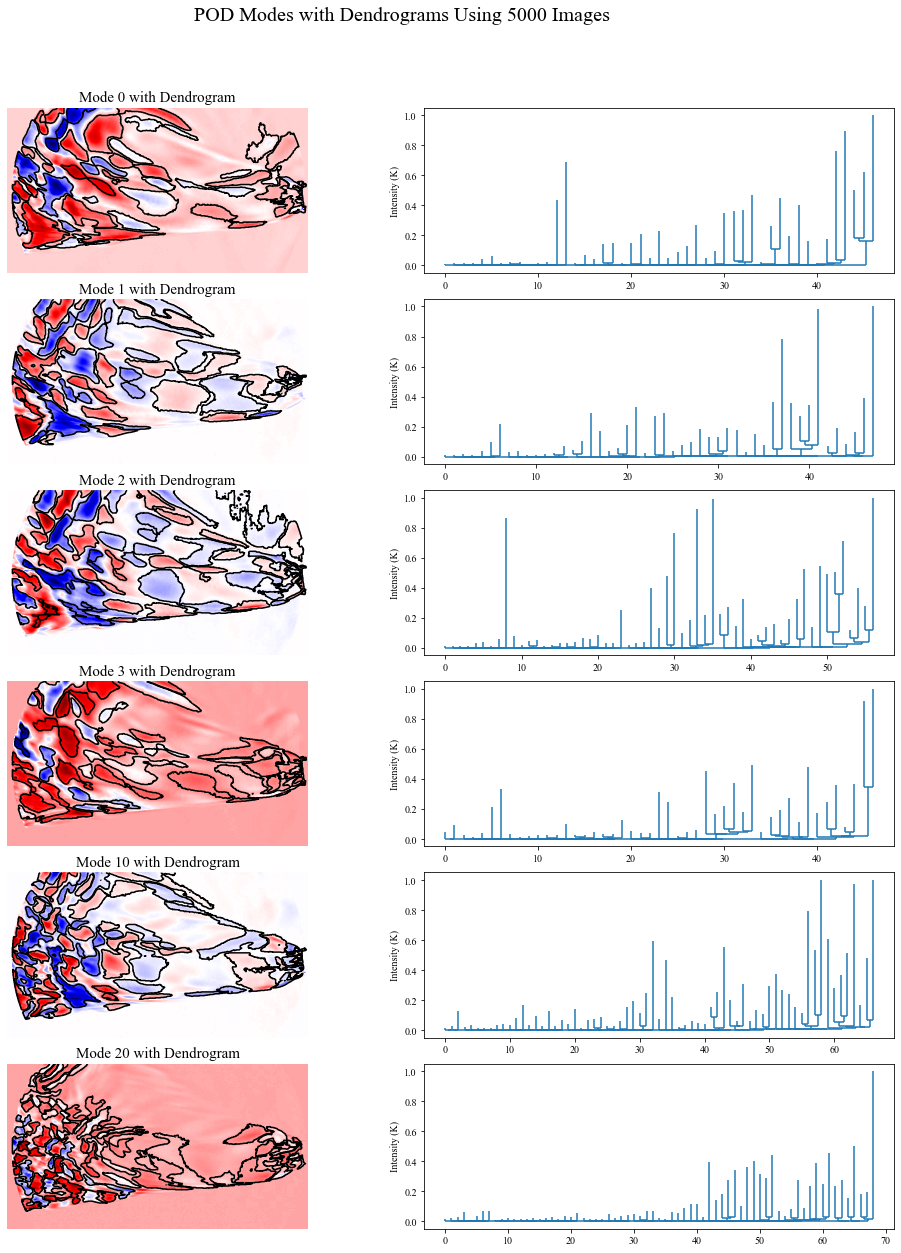

In [24]:
figure, ax = plt.subplots(6,2)
figure.set_size_inches(14,16)
figure.tight_layout(pad=0.5)

plt.rcParams["font.family"] = "Times New Roman"

figure.suptitle('POD Modes with Dendrograms Using 5000 Images', fontsize=20, y = 1.08)


for i in range(6):
    # We have to have all the fluctiations positive for the dendrogram to find everything the right way
    im = (basis_modes_5k[:,:,i]/abs(basis_modes_5k[:,:,i]).max())**2
    d = Dendrogram.compute(im,min_delta=0.01, min_npix=400) # All dendrogram code came from LaLonde and Brun Prjoect 2.
    p = d.plotter() # All dendrogram code came from LaLonde and Brun Prjoect 2.
    
    for j in range(2):
        plt.sca(ax[i,j])
    
        if j == 0:
            mode = plt.imshow(basis_modes_5k[:,:,i], cmap = 'seismic')
            plt.title('Mode ' + str(modes_wanted_5k[i]) + ' with Dendrogram', fontsize = 15)
            ax[i,j].axis('off') # Hide the xy axis marks, they just show pixel counts
            
            for leaf in d.leaves: # All dendrogram code came from LaLonde and Brun Prjoect 2.
                p.plot_contour(plt.gca(), structure=leaf, colors='black') # All dendrogram code came from LaLonde and Brun Prjoect 2.
            
        if j == 1:
            d.plotter().plot_tree(plt.gca()) # All dendrogram code came from LaLonde and Brun Prjoect 2. 
            plt.ylabel("Intensity (K)") # All dendrogram code came from LaLonde and Brun Prjoect 2.
            
plt.savefig('POD Modes and dend with 5k images.tif', dpi=300, bbox_inches='tight')

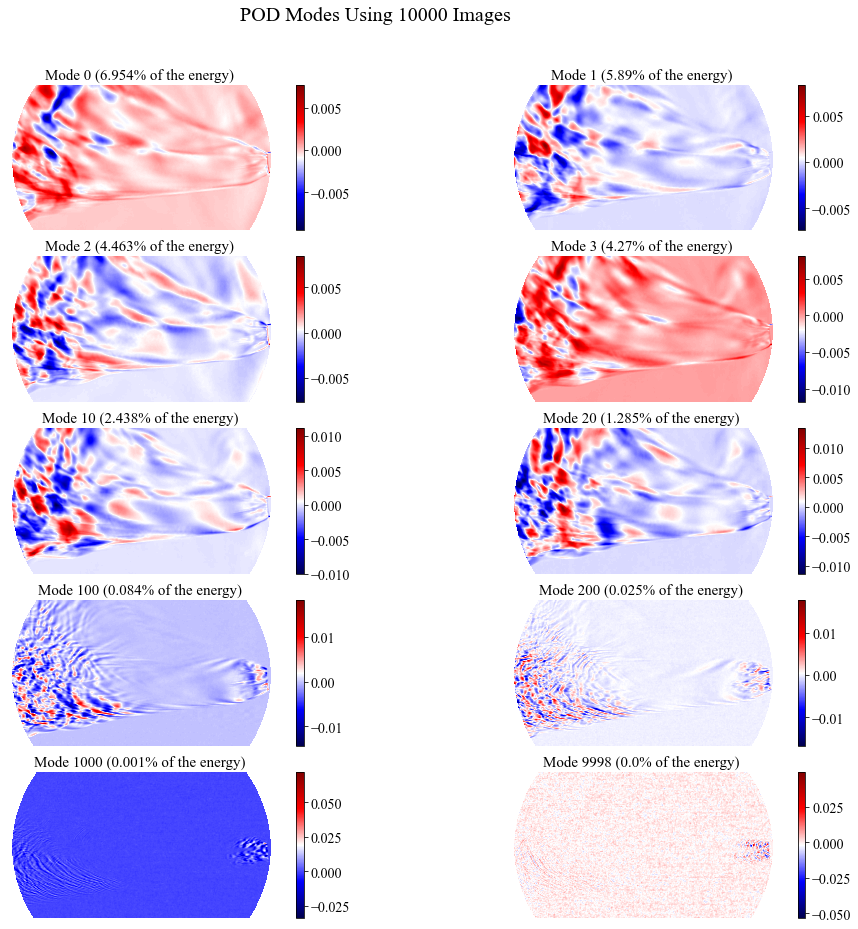

In [25]:
figure, ax = plt.subplots(5,2)
figure.set_size_inches(14,12)
figure.tight_layout(pad=0.5)

plt.rcParams["font.family"] = "Times New Roman"

figure.suptitle('POD Modes Using 10000 Images', fontsize=20, y = 1.08)

k = 0
for i in range(5):
    for j in range(2):
                
        plt.sca(ax[i,j])
        mode = plt.imshow(np.ma.array(basis_modes_10k[:,:,k], mask = mask_array), cmap = 'seismic')
        cbar = figure.colorbar(mode)     
        cbar.ax.tick_params(labelsize=14) 
        plt.title('Mode ' + str(modes_wanted_10k[k]) + ' (' + str(round(norm_lamb_10k[modes_wanted_10k[k]],3)) 
                  + '% of the energy)', fontsize = 15)
        ax[i,j].axis('off') # Hide the xy axis marks, they just show pixel counts
        k += 1
        
plt.savefig('POD Modes with 10k images.tif', dpi=300, bbox_inches='tight')

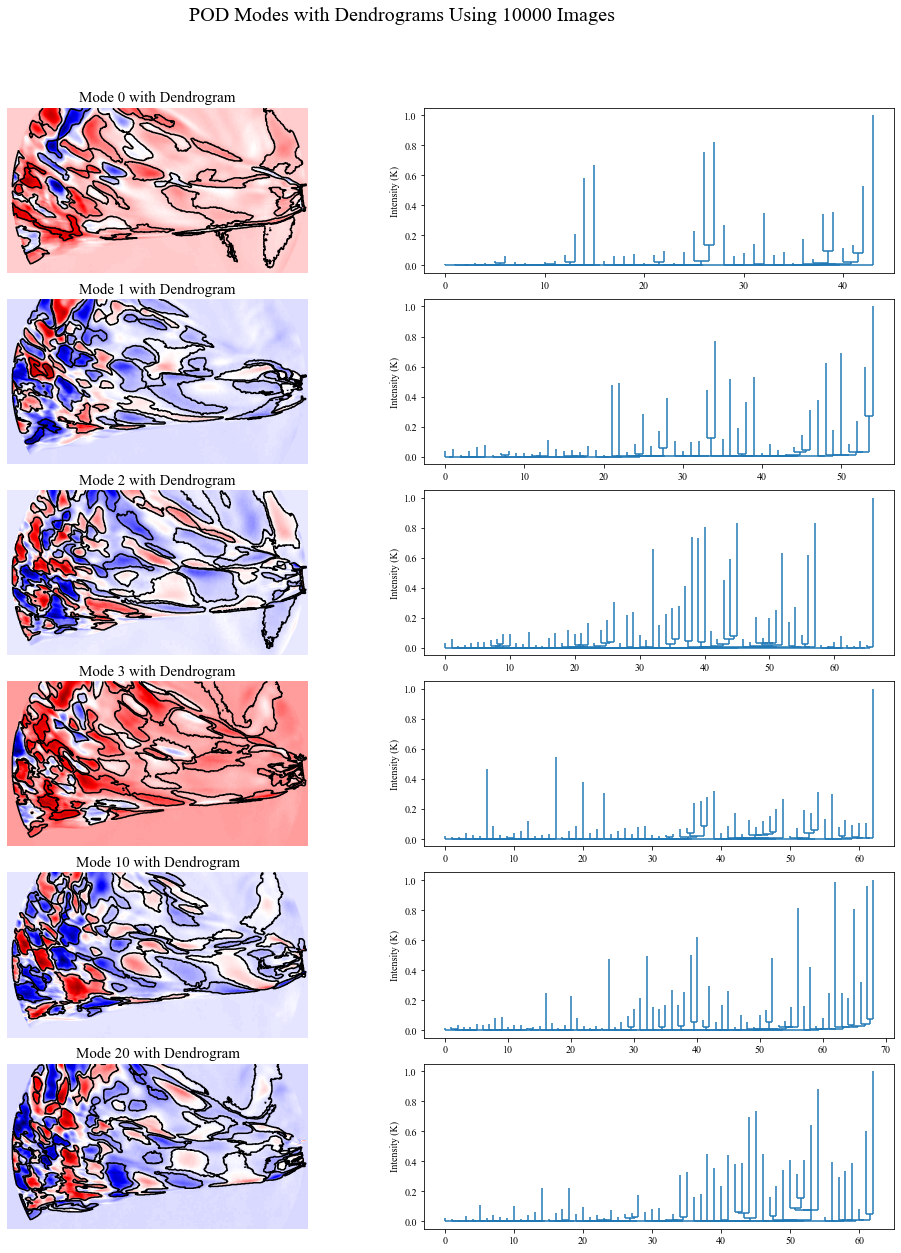

In [26]:
figure, ax = plt.subplots(6,2)
figure.set_size_inches(14,16)
figure.tight_layout(pad=0.5)

plt.rcParams["font.family"] = "Times New Roman"

figure.suptitle('POD Modes with Dendrograms Using 10000 Images', fontsize=20, y = 1.08)


for i in range(6):
    # We have to have all the fluctiations positive for the dendrogram to find everything the right way
    im = (basis_modes_10k[:,:,i]/abs(basis_modes_10k[:,:,i]).max())**2
    d = Dendrogram.compute(im,min_delta=0.01, min_npix=400) # All dendrogram code came from LaLonde and Brun Prjoect 2.
    p = d.plotter() # All dendrogram code came from LaLonde and Brun Prjoect 2.
    
    for j in range(2):
        plt.sca(ax[i,j])
    
        if j == 0:
            mode = plt.imshow(basis_modes_10k[:,:,i], cmap = 'seismic')
            plt.title('Mode ' + str(modes_wanted_10k[i]) + ' with Dendrogram', fontsize = 15)
            ax[i,j].axis('off') # Hide the xy axis marks, they just show pixel counts
            
            for leaf in d.leaves: # All dendrogram code came from LaLonde and Brun Prjoect 2.
                p.plot_contour(plt.gca(), structure=leaf, colors='black') # All dendrogram code came from LaLonde and Brun Prjoect 2.
            
        if j == 1:
            d.plotter().plot_tree(plt.gca())  # All dendrogram code came from LaLonde and Brun Prjoect 2.
            plt.ylabel("Intensity (K)") # All dendrogram code came from LaLonde and Brun Prjoect 2.
            
plt.savefig('POD Modes and dend with 10k images.tif', dpi=300, bbox_inches='tight')

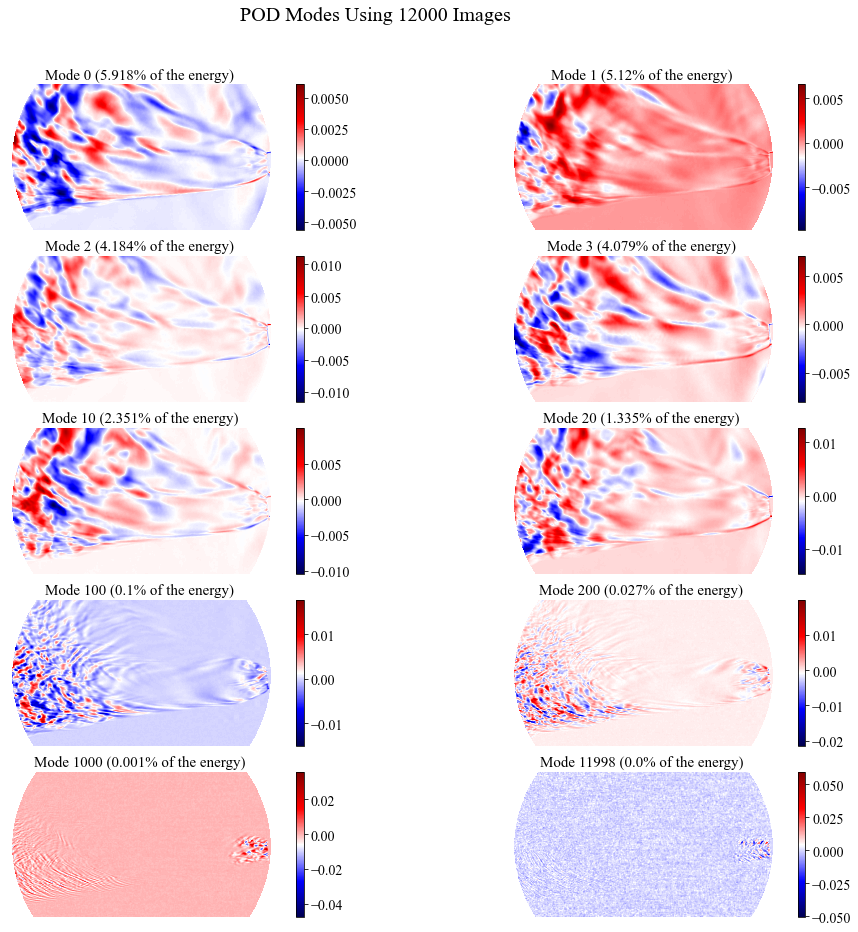

In [27]:
figure, ax = plt.subplots(5,2)
figure.set_size_inches(14,12)
figure.tight_layout(pad=0.5)

plt.rcParams["font.family"] = "Times New Roman"

figure.suptitle('POD Modes Using 12000 Images', fontsize=20, y = 1.08)

k = 0
for i in range(5):
    for j in range(2):
                
        plt.sca(ax[i,j])
        mode = plt.imshow(np.ma.array(basis_modes_12k[:,:,k], mask = mask_array), cmap = 'seismic')
        cbar = figure.colorbar(mode)     
        cbar.ax.tick_params(labelsize=14) 
        plt.title('Mode ' + str(modes_wanted_12k[k]) + ' (' + str(round(norm_lamb_12k[modes_wanted_12k[k]],3)) 
                  + '% of the energy)', fontsize = 15)
        ax[i,j].axis('off') # Hide the xy axis marks, they just show pixel counts
        k += 1
        
plt.savefig('POD Modes with 12k images.tif', dpi=300, bbox_inches='tight')

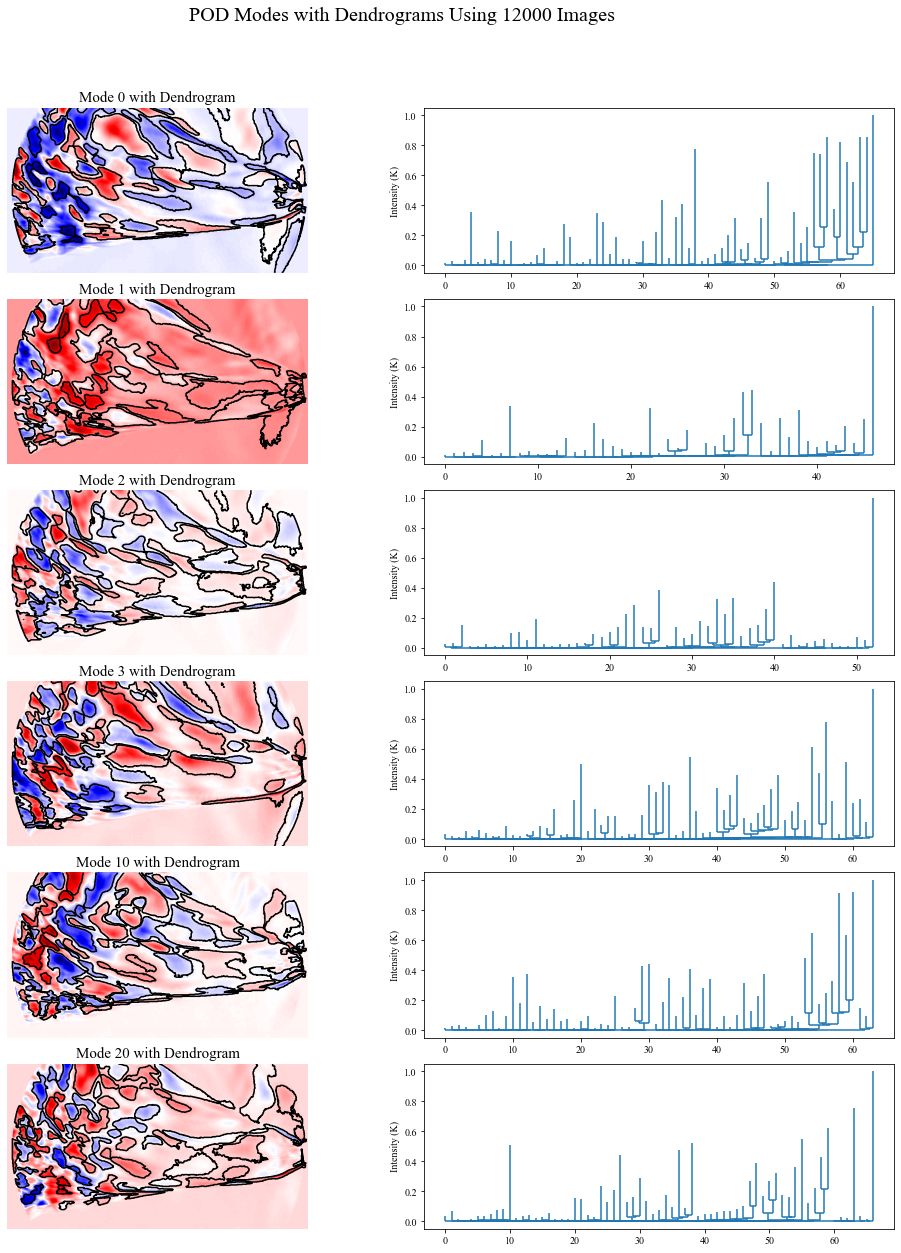

In [28]:
figure, ax = plt.subplots(6,2)
figure.set_size_inches(14,16)
figure.tight_layout(pad=0.5)

plt.rcParams["font.family"] = "Times New Roman"

figure.suptitle('POD Modes with Dendrograms Using 12000 Images', fontsize=20, y = 1.08)


for i in range(6):
    # We have to have all the fluctiations positive for the dendrogram to find everything the right way
    im = (basis_modes_12k[:,:,i]/abs(basis_modes_12k[:,:,i]).max())**2
    d = Dendrogram.compute(im,min_delta=0.01, min_npix=400) # All dendrogram code came from LaLonde and Brun Prjoect 2.
    p = d.plotter() # All dendrogram code came from LaLonde and Brun Prjoect 2.
    
    for j in range(2):
        plt.sca(ax[i,j])
    
        if j == 0:
            mode = plt.imshow(basis_modes_12k[:,:,i], cmap = 'seismic')
            plt.title('Mode ' + str(modes_wanted_12k[i]) + ' with Dendrogram', fontsize = 15)
            ax[i,j].axis('off') # Hide the xy axis marks, they just show pixel counts
            
            for leaf in d.leaves: # All dendrogram code came from LaLonde and Brun Prjoect 2.
                p.plot_contour(plt.gca(), structure=leaf, colors='black') # All dendrogram code came from LaLonde and Brun Prjoect 2.
            
        if j == 1:
            d.plotter().plot_tree(plt.gca())  # All dendrogram code came from LaLonde and Brun Prjoect 2.
            plt.ylabel("Intensity (K)") # All dendrogram code came from LaLonde and Brun Prjoect 2.
            
plt.savefig('POD Modes and dend with 12k images.tif', dpi=300, bbox_inches='tight')

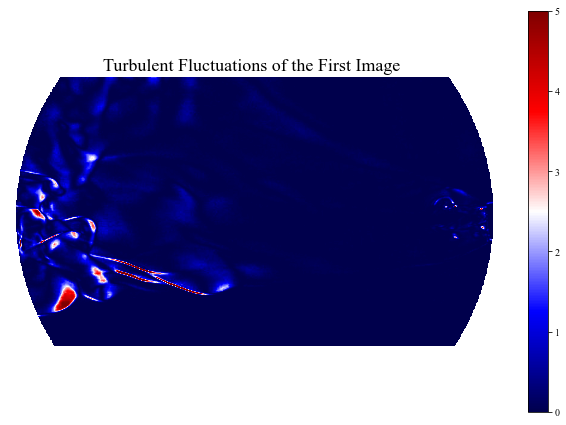

In [29]:
TF = (imgs[0,:,:]-np.mean(imgs, axis = 0))**2/np.mean(imgs, axis = 0)

figure, ax = plt.subplots(1)
figure.set_size_inches(9,6)
figure.tight_layout(pad=0.5)

plt.rcParams["font.family"] = "Times New Roman"

plt.imshow(TF, cmap = 'seismic', vmin = 0, vmax = 5)
plt.colorbar()
plt.title('Turbulent Fluctuations of the First Image', fontsize = 18)
plt.axis('off')
plt.savefig('Turbulent Fluctuations.tif', dpi=300, bbox_inches='tight')

In [30]:
_ = saved_corr_modes_2k.seek(0) # Only needed here to simulate closing & reopening file
corr_modes_2k = np.load(saved_corr_modes_2k)

_ = saved_corr_modes_3k.seek(0) # Only needed here to simulate closing & reopening file
corr_modes_3k = np.load(saved_corr_modes_3k)

_ = saved_corr_modes_4k.seek(0) # Only needed here to simulate closing & reopening file
corr_modes_4k = np.load(saved_corr_modes_4k)

_ = saved_corr_modes_5k.seek(0) # Only needed here to simulate closing & reopening file
corr_modes_5k = np.load(saved_corr_modes_5k)

_ = saved_corr_modes_10k.seek(0) # Only needed here to simulate closing & reopening file
corr_modes_10k = np.load(saved_corr_modes_10k)

_ = saved_corr_modes_12k.seek(0) # Only needed here to simulate closing & reopening file
corr_modes_12k = np.load(saved_corr_modes_12k)

In [31]:
for j in range(X):
    for k in range(Y):
        if np.sqrt((j-Y_center)**2 +(k-X_center)**2) >= radius:
            corr_modes_2k[j,k,:] = 0
            corr_modes_3k[j,k,:] = 0
            corr_modes_4k[j,k,:] = 0
            corr_modes_5k[j,k,:] = 0
            corr_modes_10k[j,k,:] = 0
            corr_modes_12k[j,k,:] = 0
        else:
            corr_modes_2k[j,k,:] = corr_modes_2k[j,k,:]
            corr_modes_3k[j,k,:] = corr_modes_3k[j,k,:]
            corr_modes_4k[j,k,:] = corr_modes_4k[j,k,:]
            corr_modes_5k[j,k,:] = corr_modes_5k[j,k,:]
            corr_modes_10k[j,k,:] = corr_modes_10k[j,k,:]
            corr_modes_12k[j,k,:] = corr_modes_12k[j,k,:]
            
corr_modes_2k = (corr_modes_2k/abs(corr_modes_2k).max())**2
corr_modes_3k = (corr_modes_3k/abs(corr_modes_3k).max())**2
corr_modes_4k = (corr_modes_4k/abs(corr_modes_4k).max())**2
corr_modes_5k = (corr_modes_5k/abs(corr_modes_5k).max())**2
corr_modes_10k = (corr_modes_10k/abs(corr_modes_10k).max())**2
corr_modes_12k = (corr_modes_12k/abs(corr_modes_12k).max())**2

In [32]:
modes_2k = pd.DataFrame(corr_modes_2k.reshape(-1, len(corr_modes_2k[0,0,:])))
modes_3k = pd.DataFrame(corr_modes_3k.reshape(-1, len(corr_modes_3k[0,0,:])))
modes_4k = pd.DataFrame(corr_modes_4k.reshape(-1, len(corr_modes_4k[0,0,:])))
modes_5k = pd.DataFrame(corr_modes_5k.reshape(-1, len(corr_modes_5k[0,0,:])))
modes_10k = pd.DataFrame(corr_modes_10k.reshape(-1, len(corr_modes_10k[0,0,:])))
modes_12k = pd.DataFrame(corr_modes_12k.reshape(-1, len(corr_modes_12k[0,0,:])))



basis = [modes_2k, modes_3k, modes_4k, modes_5k, modes_10k, modes_12k]

corr_matrix = np.zeros((6,6,len(corr_modes_2k[0,0,:])))
i = 0
for basis1 in basis:
    j = 0
    for basis2 in basis:
        
        corr_matrix[i,j,:] = basis1.corrwith(basis2)
        
        j += 1
        
    i += 1
    
twok_and_3k = corr_matrix[0,1,:]
twok_and_4k = corr_matrix[0,2,:]
twok_and_5k = corr_matrix[0,3,:]
twok_and_10k = corr_matrix[0,4,:]
twok_and_12k = corr_matrix[0,5,:]

threek_and_4k = corr_matrix[1,2,:]
threek_and_5k = corr_matrix[1,3,:]
threek_and_10k = corr_matrix[1,4,:]
threek_and_12k = corr_matrix[1,5,:]

fourk_and_5k = corr_matrix[2,3,:]
fourk_and_10k = corr_matrix[2,4,:]
fourk_and_12k = corr_matrix[2,5,:]

fivek_and_10k = corr_matrix[3,4,:]
fivek_and_12k = corr_matrix[3,5,:]

tenk_and_12k = corr_matrix[4,5,:]

corr_df = pd.DataFrame(np.asarray([twok_and_3k, twok_and_4k, twok_and_5k, twok_and_10k, twok_and_12k,
                                  threek_and_4k, threek_and_5k, threek_and_10k, threek_and_12k,
                                  fourk_and_5k, fourk_and_10k, fourk_and_12k,
                                  fivek_and_10k, fivek_and_12k,
                                  tenk_and_12k]).T, columns = ['2k and 3k','2k and 4k', '2k and 5k', '2k and 10k','2k and 12k', 
                                                               '3k and 4k', '3k and 5k','3k and 10k', 
                                                               '3k and 12k','4k and 5k', '4k and 10k','4k and 12k',
                                                               '5k and 10k','5k and 12k', '10k and 12k'])

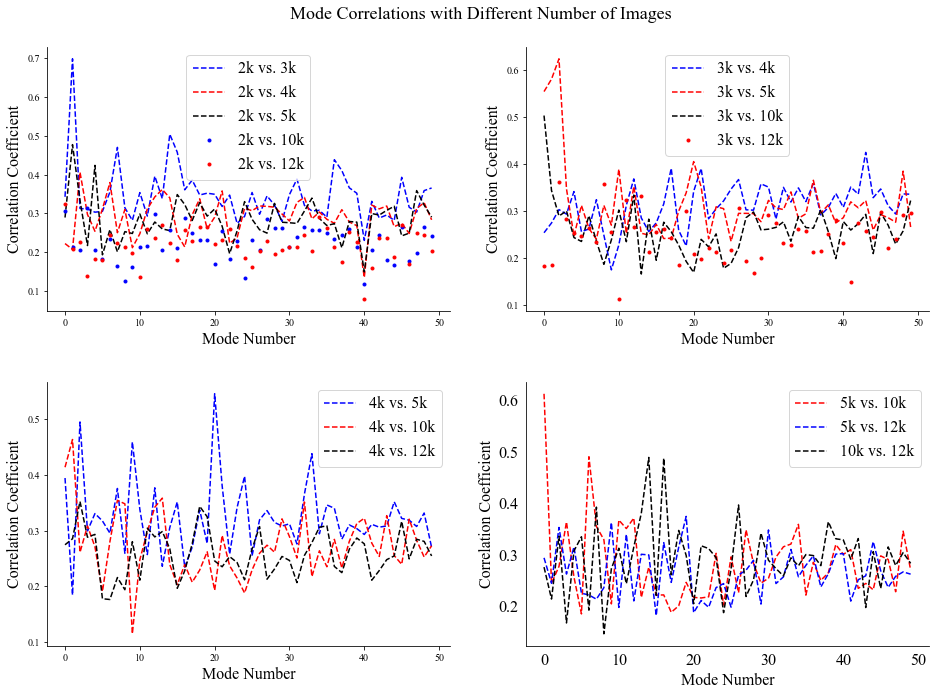

In [33]:
figure, ax = plt.subplots(2,2)
figure.set_size_inches(14,10)
figure.tight_layout(pad=5)

plt.rcParams["font.family"] = "Times New Roman"

figure.suptitle('Mode Correlations with Different Number of Images', fontsize = 18)


ax[0,0].plot(corr_df['2k and 3k'], 'b--', label = '2k vs. 3k')
ax[0,0].plot(corr_df['2k and 4k'], 'r--', label = '2k vs. 4k')
ax[0,0].plot(corr_df['2k and 5k'], 'k--', label = '2k vs. 5k')
ax[0,0].plot(corr_df['2k and 10k'], 'b.', label = '2k vs. 10k')
ax[0,0].plot(corr_df['2k and 12k'], 'r.', label = '2k vs. 12k')

ax[0,0].set_xlabel('Mode Number', fontsize = 16)
ax[0,0].set_ylabel('Correlation Coefficient', fontsize = 16)
ax[0,0].legend(fontsize = 16)

ax[0,1].plot(corr_df['3k and 4k'], 'b--', label = '3k vs. 4k')
ax[0,1].plot(corr_df['3k and 5k'], 'r--', label = '3k vs. 5k')
ax[0,1].plot(corr_df['3k and 10k'], 'k--', label = '3k vs. 10k')
ax[0,1].plot(corr_df['3k and 12k'], 'r.', label = '3k vs. 12k')

ax[0,1].set_xlabel('Mode Number', fontsize = 16)
ax[0,1].set_ylabel('Correlation Coefficient', fontsize = 16)
ax[0,1].legend(fontsize = 16)

ax[1,0].plot(corr_df['4k and 5k'], 'b--', label = '4k vs. 5k')
ax[1,0].plot(corr_df['4k and 10k'], 'r--', label = '4k vs. 10k')
ax[1,0].plot(corr_df['4k and 12k'], 'k--', label = '4k vs. 12k')

ax[1,0].set_xlabel('Mode Number', fontsize = 16)
ax[1,0].set_ylabel('Correlation Coefficient', fontsize = 16)
ax[1,0].legend(fontsize = 16)

ax[1,1].plot(corr_df['5k and 10k'], 'r--', label = '5k vs. 10k')
ax[1,1].plot(corr_df['5k and 12k'], 'b--', label = '5k vs. 12k')
ax[1,1].plot(corr_df['10k and 12k'], 'k--', label = '10k vs. 12k')

ax[1,1].set_xlabel('Mode Number', fontsize = 16)
ax[1,1].set_ylabel('Correlation Coefficient', fontsize = 16)
ax[1,1].legend(fontsize = 16)

ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)


plt.tick_params(axis = "x", which = "both", bottom = False, top = False, labelsize=16)
plt.tick_params(axis = "y", which = "both", left = False, right = False, labelsize=16)
plt.legend(fontsize = 16)

plt.savefig('Correlations.tif', dpi=300, bbox_inches='tight')

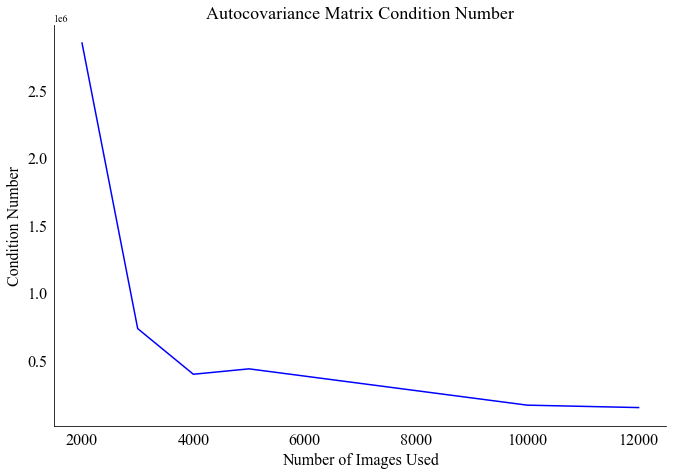

In [34]:
Num_imgs = np.array([2000, 3000, 4000, 5000, 10000, 12000])

figure, ax = plt.subplots(1)
figure.set_size_inches(9,6)
figure.tight_layout(pad=0.5)
plt.rcParams["font.family"] = "Times New Roman"

plt.plot(Num_imgs, condition_num, 'b')

plt.title('Autocovariance Matrix Condition Number', fontsize = 18)
plt.xlabel('Number of Images Used', fontsize = 16)
plt.ylabel('Condition Number', fontsize = 16)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.tick_params(axis = "x", which = "both", bottom = False, top = False, labelsize=16)
plt.tick_params(axis = "y", which = "both", left = False, right = False, labelsize=16)

plt.savefig('Condition Numbers.tif', dpi=300, bbox_inches='tight')

In [35]:
tf = time.time()
print('The total code run time was:', round((tf-t1)/3600,3), 'hours')

The total code run time was: 1.623 hours
